In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U \
  "trl==0.19.0" \
  "datasets>=3.6.0" \
  "transformers>=4.42.0" \
  "accelerate>=0.29.0" \
  "fsspec==2025.3.0" \
  "gcsfs==2025.3.0" \
  "bitsandbytes==0.46.0" \
  "peft"

In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    PeftModel,
    PeftConfig,
)
from trl import DPOTrainer, DPOConfig
from transformers import TrainerCallback


# -------------------------------------------------
# 1. DPO용 프롬프트 구성
# -------------------------------------------------
def build_dpo_prompt(example):
    prompt = f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 제주 방언 문장을 한국어 표준어로 번역.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{example['dialect']}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""
    return {
        "prompt": prompt,
        "chosen": example["standard"] + "<|eot_id|>",
        "rejected": example["rejected"] + "<|eot_id|>",
    }

df_dpo = pd.read_csv("/content/drive/MyDrive/jeju_ppodpo/data/df_dpo.csv")
df_dpo = df_dpo.iloc[15000:, :]
dataset_dpo = Dataset.from_pandas(df_dpo).map(build_dpo_prompt)
dataset_dpo = dataset_dpo.train_test_split(test_size=0.05)

# -------------------------------------------------
# 2. 토크나이저 및 SFT 모델 경로/구성 로드
# -------------------------------------------------
sft_model_path = "/content/drive/MyDrive/jeju_ppodpo/jeju_sft"
peft_config = PeftConfig.from_pretrained(sft_model_path)

tokenizer = AutoTokenizer.from_pretrained(sft_model_path, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

# -------------------------------------------------
# 3. base_model 로드 및 LoRA 적용
# -------------------------------------------------
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,  # 수정된 부분
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
base_model = prepare_model_for_kbit_training(base_model)

# LoRA 설정 적용 (수동으로 지정하거나 필요시 peft_config로부터 변환 가능)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # 모델 구조에 따라 조정
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()  # 학습 가능 파라미터 확인

# -------------------------------------------------
# 4. ref_model은 base_model을 새로 로드해서 사용
# -------------------------------------------------
ref_base_model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

ref_model = PeftModel.from_pretrained(ref_base_model, sft_model_path)
ref_model.eval()
ref_model.requires_grad_(False)
ref_model.print_trainable_parameters()  # 0개여야 정상
model.print_trainable_parameters()  # 학습 가능 파라미터 확인

tokenizer.add_special_tokens({
    "additional_special_tokens": [
        "<|begin_of_text|>",
        "<|start_header_id|>",
        "<|end_header_id|>",
        "<|eot_id|>"
    ]
})
model.resize_token_embeddings(len(tokenizer))
ref_model.resize_token_embeddings(len(tokenizer))


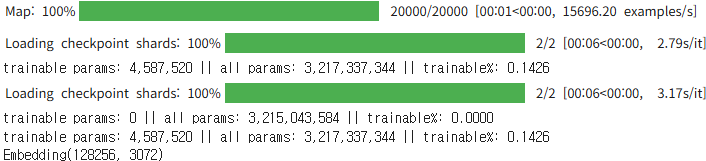

In [ ]:
from transformers import EarlyStoppingCallback

# -------------------------------------------------
# 4. DPO 학습 설정
# -------------------------------------------------
dpo_config = DPOConfig(
    output_dir="/content/drive/MyDrive/jeju_ppodpo/jeju_dpo_temp",
    beta=0.01,
    max_length=256,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=5e-5,
    logging_steps=100,
    eval_steps=100,
    save_steps=600,
    fp16=False,
    bf16=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# -------------------------------------------------
# 5. 평가 출력 콜백
# -------------------------------------------------
class EvalPromptPrinterCallback(TrainerCallback):
    def __init__(self, tokenizer, raw_eval_dataset):
        self.tokenizer = tokenizer
        self.raw_eval_dataset = raw_eval_dataset  # 원본 텍스트 포함된 데이터셋

    def on_evaluate(self, args, state, control, model=None, eval_dataloader=None, **kwargs):
        tokenizer = self.tokenizer
        raw_dataset = self.raw_eval_dataset

        print(f"\n [Evaluation @ Step {state.global_step}] ===============================")

        for i in range(5):  # 상위 3개 샘플
            prompt = raw_dataset[i]["prompt"]
            chosen = raw_dataset[i]["chosen"]

            input_ids = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).input_ids.to(model.device)
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=input_ids,
                    max_new_tokens=128,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                )
            decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

            print(f"\nPrompt {i+1}:\n")
            print(f"\nChosen (reference):\n{chosen}")
            print(f"\nModel Output:\n{decoded_output}")
            print("=" * 60)

# -------------------------------------------------
# 5. DPOTrainer 정의 및 학습
# -------------------------------------------------
dpo_trainer = DPOTrainer(
    model=model,
    ref_model=ref_model,
    args=dpo_config,
    train_dataset=dataset_dpo["train"],
    eval_dataset=dataset_dpo["test"],
    processing_class=tokenizer,
    callbacks=[
        EvalPromptPrinterCallback(tokenizer, raw_eval_dataset=dataset_dpo["test"]),
        EarlyStoppingCallback(early_stopping_patience=3),  # 추가
    ],
)

dpo_trainer.train()


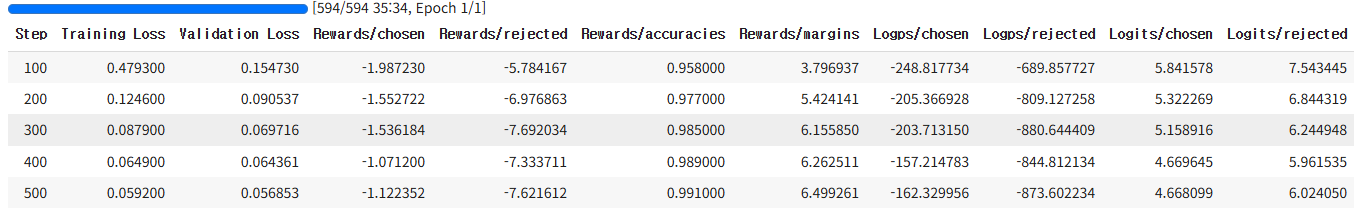

In [ ]:
# -------------------------------------------------
# 6. 모델 저장
# -------------------------------------------------
model.save_pretrained("/content/drive/MyDrive/jeju_ppodpo/jeju_dpo")
tokenizer.save_pretrained("/content/drive/MyDrive/jeju_ppodpo/jeju_dpo")

In [ ]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch

# ---------------------------------------------
# 1. 평가용 데이터셋 로드
# ---------------------------------------------
df_test = pd.read_csv("/content/drive/MyDrive/jeju_ppodpo/data/df_test.csv")
df_test = df_test.head(1000)  # 원하는 수 만큼 자르기

# ---------------------------------------------
# 2. 프롬프트 생성 함수
# ---------------------------------------------
def make_prompt(dialect):
    return f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 제주 방언 문장을 한국어 표준어로 번역.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{dialect}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

# ---------------------------------------------
# 3. BLEU 계산 함수
# ---------------------------------------------
def compute_bleu_scores(preds, refs):
    smoothie = SmoothingFunction().method4
    scores = [
        sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie)
        for pred, ref in zip(preds, refs)
    ]
    return np.mean(scores)

# ---------------------------------------------
# 4. DPO 모델 평가 수행
# ---------------------------------------------
model.eval()

predictions = []
references = df_test["standard"].tolist()

for dialect in tqdm(df_test["dialect"].tolist(), desc="Evaluating"):
    prompt = make_prompt(dialect)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    full_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # 프롬프트 제거 (모델이 프롬프트도 재생성하는 경우 대비)
    if "<|start_header_id|>assistant<|end_header_id|>" in prompt:
        output = full_output.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
    else:
        output = full_output.replace(prompt.strip(), "").strip()

    predictions.append(output)

# ---------------------------------------------
# 5. BLEU 계산 및 출력
# ---------------------------------------------
bleu_score = compute_bleu_scores(predictions, references)
print(f"\n BLEU Score: {bleu_score:.4f}")


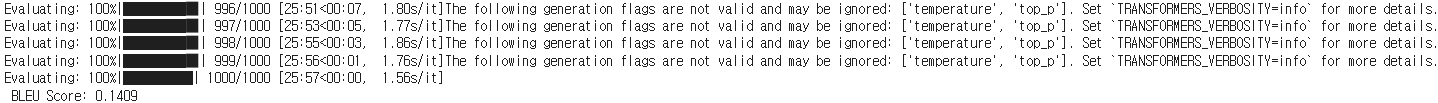